#### ДЗ_29 - классифкация текста по эмоциональной окраске
#### Татур А.А.
##### 06.03.2023
##### v.0.1

##### Задача: используя сет с набором твитов построить классификатор по эмоциональной окраске с использованием рекуррентных сетей.

In [359]:
import numpy as np
import pandas as pd
import os

import re
import emoji
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS  = stopwords.words('english') + ['im']

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Dropout, GRU, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

In [273]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [281]:
#### Функция для очистки текста и лемматизации

def cleaner(tweet):
    tweet = tweet.lower() # приводим к нижнему регистру
    tweet = tweet.replace("<unk>", "") #убираем значение <unk>, которое встречается в некоторых строках
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #убираем ссылки
    tweet = re.sub(r'[^\w\s]', '', tweet) #убираем знаки препинания
    tweet = ''.join (c for c in tweet if c not in string.digits)  #убираем все символы, которые относятся к цифрам
    tweet = ' '.join(c for c in tweet.split() if emoji.is_emoji(c)==False \ #убираем эмодзи, знаки пунктуации и стоп-слова
                                    and c not in string.punctuation \
                                    and c not in STOPWORDS)
    tweet = tweet.replace("#", "").replace("_", " ").replace("pm","") #убираем решетки, нижние подчеркивания и обозначния времени
    
    lemmatizer = WordNetLemmatizer() #лемматизируем слова
    one_lemma = [lemmatizer.lemmatize(word) for word in tweet]
    tweet=''.join(one_lemma)
    
    return tweet

#### 01. Загружаем тренировочный и тестовый датасет

In [282]:
df_training = pd.read_csv('twitter_training.csv',
                          header=None, 
                          usecols={2,3},
                          names=['Sentiment', 'Tweet'])

df_test = pd.read_csv('twitter_validation.csv',
                            header=None, 
                            usecols={2,3},
                            names=['Sentiment', 'Tweet'])

df_training['Tweet']=df_training['Tweet'].astype(str)
df_test['Tweet']=df_test['Tweet'].astype(str)

#### 02. Проводим очистку датасетов

In [283]:
df_training['cleaned'] = df_training['Tweet'].map(lambda x: cleaner(x))
df_test['cleaned'] = df_test['Tweet'].map(lambda x: cleaner(x))

#### 03. Кодируем категориальные признаки

In [284]:
labeles = LabelEncoder()
train_labels = to_categorical(labeles.fit_transform(df_training['Sentiment']), num_classes=4)
test_labels = to_categorical(labeles.transform(df_test['Sentiment']), num_classes=4)

#### 04. Токенизируем текст

In [301]:
tokenizer = Tokenizer (num_words=20000,
                       lower = True,
                       split = ' ',
                       char_level=False)
tokenizer.fit_on_texts(df_training['cleaned'])

#### 05. Заполняем нулями или обрезаем предложения до 10 слов

In [336]:
max_text_len = 10
data = tokenizer.texts_to_sequences(df_training['cleaned'])
data_pad = pad_sequences (data, maxlen=max_text_len)

#### 06. Рандомизируем тренировочный сет

In [303]:
indices = np.random.choice (X.shape[0], size = X.shape[0], replace=False)
X=data_pad[indices]
y=train_labels[indices]

#### 07 Создаем валидационный и тренировочный наборы

In [304]:
X_train = X[:60000]; X_val=X[60000:]
y_train = y[:60000]; y_val=y[60000:]

#### 08. Создаем тестовый набор

In [305]:
data_test = tokenizer.texts_to_sequences(df_test['cleaned'])
data_test_pad = pad_sequences (data_test, maxlen=max_text_len)

In [306]:
X_test = data_test_pad
y_test = test_labels

#### 09. Строим модель и проводим ее обучение

In [415]:
model = Sequential()
model.add (Embedding(maxWordsCount, 128, input_length=max_text_len))
model.add (GRU(128, return_sequences=True))
model.add (GRU(128))
model.add (BatchNormalization())
model.add (Dense(1000, activation='relu'))
model.add (BatchNormalization())
model.add (Dense(4, activation='linear'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 10, 128)           2560000   
                                                                 
 gru_18 (GRU)                (None, 10, 128)           99072     
                                                                 
 gru_19 (GRU)                (None, 128)               99072     
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 1000)              129000    
                                                                 
 batch_normalization_13 (Bat  (None, 1000)             4000      
 chNormalization)                                    

In [416]:
model.compile (optimizer=Adam(0.0001),
               loss = CategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

In [417]:
checkpoint_cb_conv = ModelCheckpoint("model.h5", 
                                     monitor = 'val_accuracy',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [418]:
history = model.fit (X_train, y_train, 
                     batch_size=64, 
                     epochs=20,
                     validation_data = (X_val, y_val),
                     callbacks=[checkpoint_cb_conv,lr_scheduler])

Epoch 1/20
938/938 [==============================] - 18s 15ms/step - loss: 1.1371 - accuracy: 0.5177 - val_loss: 0.9093 - val_accuracy: 0.6419 - lr: 1.0000e-04
Epoch 2/20
938/938 [==============================] - 14s 15ms/step - loss: 0.6079 - accuracy: 0.7750 - val_loss: 0.6647 - val_accuracy: 0.7571 - lr: 1.0000e-04
Epoch 3/20
938/938 [==============================] - 14s 14ms/step - loss: 0.3566 - accuracy: 0.8742 - val_loss: 0.5166 - val_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 4/20
938/938 [==============================] - 14s 15ms/step - loss: 0.2421 - accuracy: 0.9148 - val_loss: 0.4795 - val_accuracy: 0.8338 - lr: 1.0000e-04
Epoch 5/20
938/938 [==============================] - 14s 15ms/step - loss: 0.1898 - accuracy: 0.9319 - val_loss: 0.4900 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 6/20
938/938 [==============================] - 16s 17ms/step - loss: 0.1581 - accuracy: 0.9424 - val_loss: 0.4672 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 7/20
938/938 [==============

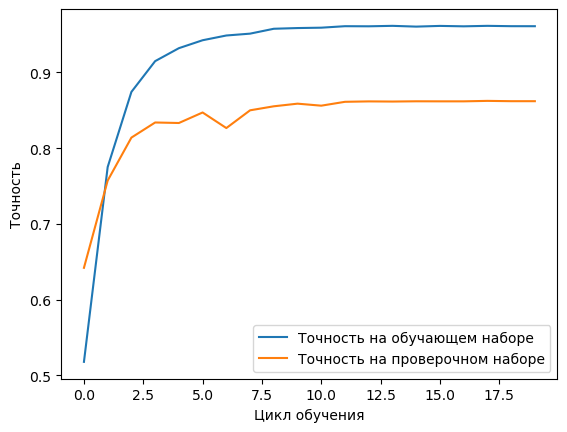

In [419]:
test_val_graph (history,'accuracy', 'val_accuracy')

#### 10. Оценка эффективности модели на тестовом наборе

In [420]:
model = load_model("model.h5")

In [421]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 5ms/step - loss: 0.3062 - accuracy: 0.9350


[0.30623185634613037, 0.9350000023841858]

#### 11. Создадим функцию для проверки модели на собственных предложениях

In [368]:
def text_checker (text):
    t_cleaned = cleaner (text)
    data = tokenizer.texts_to_sequences([t_cleaned])
    data_pad = pad_sequences (data, maxlen=max_text_len)
    res = model.predict(data_pad)
    print ('Окраска текста - ', labeles.classes_[np.argmax(res)])

In [369]:
text_checker('this idea is absolutely bullshit')

1/1 [==============================] - 1s 767ms/step
Окраска текста -  Negative


In [378]:
text_checker('this idea is absolutely brilliant')

1/1 [==============================] - 0s 28ms/step
Окраска текста -  Positive


In [371]:
text_checker("i don't think this is a good idea")

1/1 [==============================] - 0s 29ms/step
Окраска текста -  Positive


In [372]:
text_checker("i think this is a bad idea")

1/1 [==============================] - 0s 27ms/step
Окраска текста -  Negative


In [373]:
text_checker("knock the door from the other side")

1/1 [==============================] - 0s 28ms/step
Окраска текста -  Neutral


In [374]:
text_checker("fuck off")

1/1 [==============================] - 0s 29ms/step
Окраска текста -  Negative


In [375]:
text_checker("knock yourself out")

1/1 [==============================] - 0s 28ms/step
Окраска текста -  Negative


In [376]:
text_checker("come out")

1/1 [==============================] - 0s 27ms/step
Окраска текста -  Irrelevant


In [377]:
text_checker("go on")

1/1 [==============================] - 0s 31ms/step
Окраска текста -  Positive
